# Анализ оттока клиентов фитнес-центра Культурист-датасаентист

Задача: Проанализировать отток клиентов клуба и подготовить план действий по удержанию клиентов.

В нашем распоряжении имеются:

Данные клиента за предыдущий до проверки факта оттока месяц:


- 'gender' — пол;
- 'Near_Location' — проживание или работа в районе, где находится фитнес-центр;
- 'Partner' — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент  в таком случае фитнес-центр хранит информацию о работодателе клиента);
- Promo_friends — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента);
- 'Phone' — наличие контактного телефона;
- 'Age' — возраст;
- 'Lifetime' — время с момента первого обращения в фитнес-центр (в месяцах).


Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента:


- 'Contract_period' — длительность текущего действующего абонемента (месяц, 6 месяцев, год);
- 'Month_to_end_contract' — срок до окончания текущего действующего абонемента (в месяцах);
- 'Group_visits' — факт посещения групповых занятий;
- 'Avg_class_frequency_total' — средняя частота посещений в неделю за все время с начала действия абонемента;
- 'Avg_class_frequency_current_month' — средняя частота посещений в неделю за предыдущий месяц;
- 'Avg_additional_charges_total' — суммарная выручка от других услуг фитнес-центра: кафе, спорттовары, косметический и массажный салон.
- 'Churn' — факт оттока в текущем месяце.
    
    

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import itertools
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from scipy.cluster.hierarchy import dendrogram, linkage
from IPython.display import display
import warnings

warnings.filterwarnings('ignore')

# Знакомство с данными

In [2]:
data = 'gym_churn.csv'
try:
    df= pd.read_csv(data)
except:
    df=pd.read_csv('/datasets/gym_churn.csv')

In [3]:
df.head()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


In [4]:
df.shape

(4000, 14)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

In [6]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
gender,4000.0,0.510250,0.499957,0.000000,0.000000,1.000000,1.000000,1.000000
Near_Location,4000.0,0.845250,0.361711,0.000000,1.000000,1.000000,1.000000,1.000000
Partner,4000.0,0.486750,0.499887,0.000000,0.000000,0.000000,1.000000,1.000000
Promo_friends,4000.0,0.308500,0.461932,0.000000,0.000000,0.000000,1.000000,1.000000
Phone,4000.0,0.903500,0.295313,0.000000,1.000000,1.000000,1.000000,1.000000
Contract_period,4000.0,4.681250,4.549706,1.000000,1.000000,1.000000,6.000000,12.000000
Group_visits,4000.0,0.412250,0.492301,0.000000,0.000000,0.000000,1.000000,1.000000
Age,4000.0,29.184250,3.258367,18.000000,27.000000,29.000000,31.000000,41.000000
Avg_additional_charges_total,4000.0,146.943728,96.355602,0.148205,68.868830,136.220159,210.949625,552.590740
Month_to_end_contract,4000.0,4.322750,4.191297,1.000000,1.000000,1.000000,6.000000,12.000000


In [7]:
df.duplicated().sum()

0

Данные в прекрасном состоянии, пропусков и дубликатов нет

In [8]:
df.columns = df.columns.str.lower() # приведем названия столбцов к змеиному регистру


# Исследовательский анализ данных (EDA)

In [9]:
gone = df.query('churn == True')
gone.describe().T

,count,mean,std,min,25%,50%,75%,max
gender,1061.0,0.510839,0.500118,0.000000,0.000000,1.000000,1.000000,1.000000
near_location,1061.0,0.768143,0.422217,0.000000,1.000000,1.000000,1.000000,1.000000
partner,1061.0,0.355325,0.478837,0.000000,0.000000,0.000000,1.000000,1.000000
promo_friends,1061.0,0.183789,0.387495,0.000000,0.000000,0.000000,0.000000,1.000000
phone,1061.0,0.902922,0.296204,0.000000,1.000000,1.000000,1.000000,1.000000
contract_period,1061.0,1.728558,2.132371,1.000000,1.000000,1.000000,1.000000,12.000000
group_visits,1061.0,0.268615,0.443448,0.000000,0.000000,0.000000,1.000000,1.000000
age,1061.0,26.989632,2.895163,18.000000,25.000000,27.000000,29.000000,38.000000
avg_additional_charges_total,1061.0,115.082899,77.696419,0.148205,50.629127,103.814686,165.616858,425.535220
month_to_end_contract,1061.0,1.662582,1.964593,1.000000,1.000000,1.000000,1.000000,12.000000


In [10]:
not_gone = df.query('churn == False')
not_gone.describe().T

,count,mean,std,min,25%,50%,75%,max
gender,2939.0,0.510037,0.499984,0.000000,0.000000,1.000000,1.000000,1.000000
near_location,2939.0,0.873086,0.332933,0.000000,1.000000,1.000000,1.000000,1.000000
partner,2939.0,0.534195,0.498914,0.000000,0.000000,1.000000,1.000000,1.000000
promo_friends,2939.0,0.353522,0.478144,0.000000,0.000000,0.000000,1.000000,1.000000
phone,2939.0,0.903709,0.295040,0.000000,1.000000,1.000000,1.000000,1.000000
contract_period,2939.0,5.747193,4.716942,1.000000,1.000000,6.000000,12.000000,12.000000
group_visits,2939.0,0.464103,0.498795,0.000000,0.000000,0.000000,1.000000,1.000000
age,2939.0,29.976523,3.009933,19.000000,28.000000,30.000000,32.000000,41.000000
avg_additional_charges_total,2939.0,158.445715,99.801599,0.171862,76.920993,149.881171,224.448274,552.590740
month_to_end_contract,2939.0,5.283089,4.363522,1.000000,1.000000,6.000000,10.000000,12.000000


Из 4000 клиентов ушло 1061, это 26.53% - очень большой отток.

Сразу в глаза бросается среднее значение lifetime. У клиентов, которые ушли, средний срок жизнии менее месяца!

Также частота посещения зала в неделю у клиентов, которые ушли - в 2 раза меньше

In [11]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

## Графики распределения признаков 

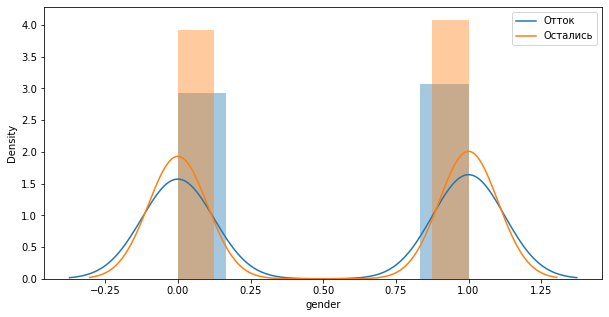

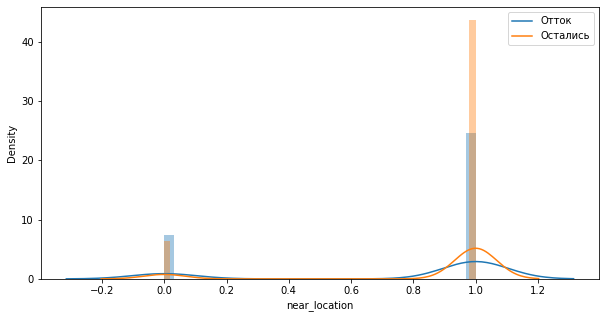

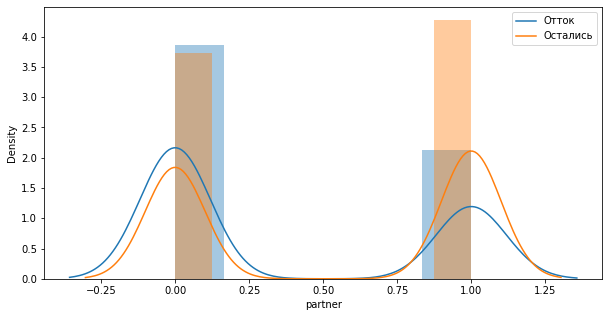

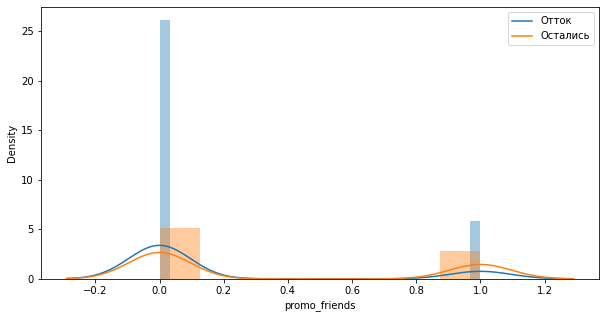

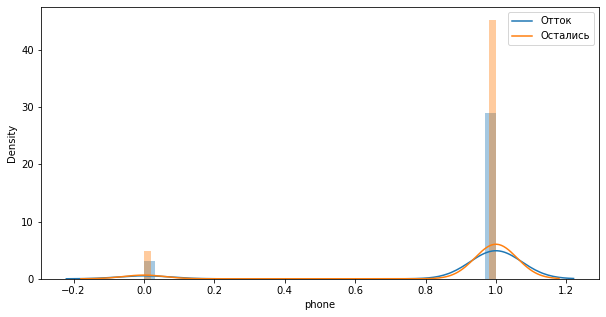

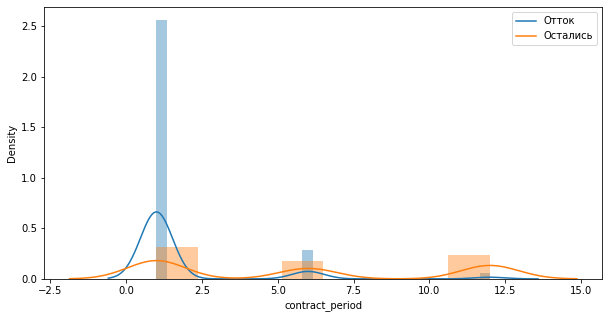

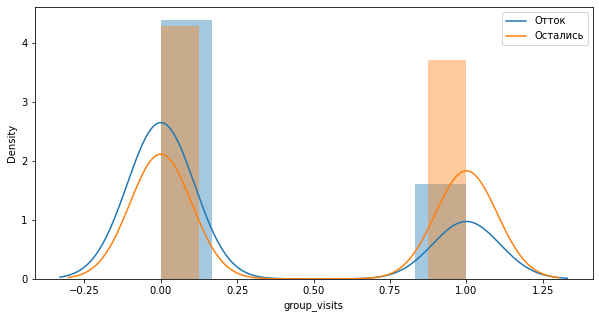

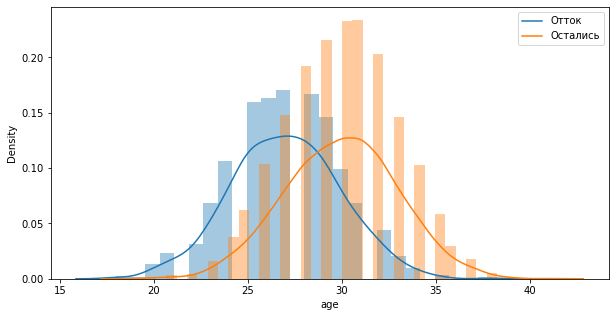

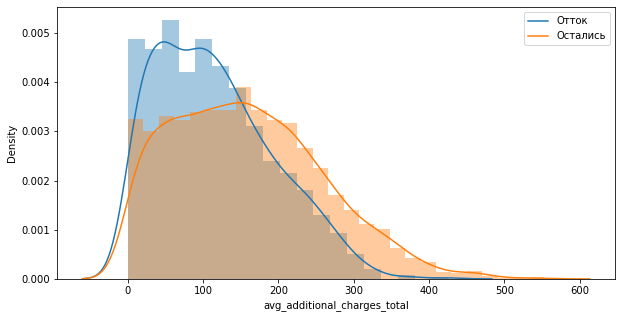

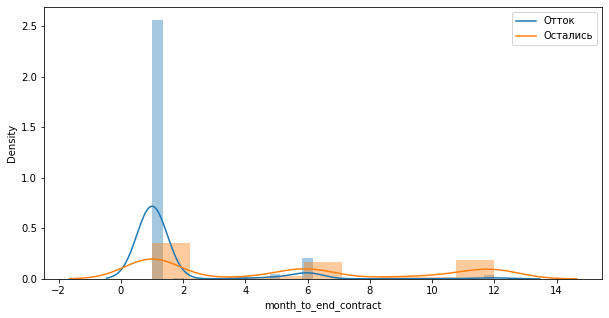

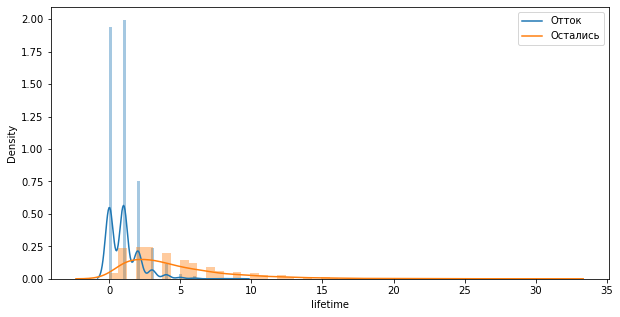

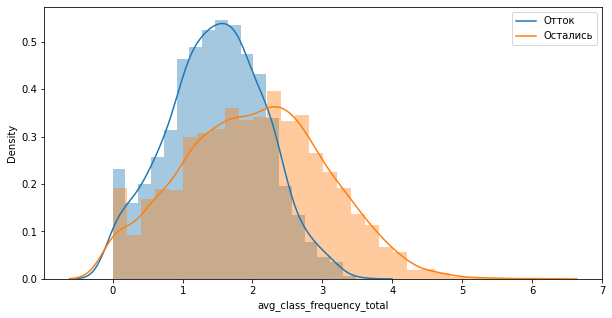

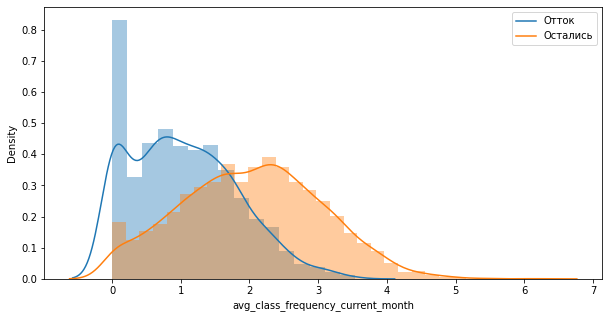

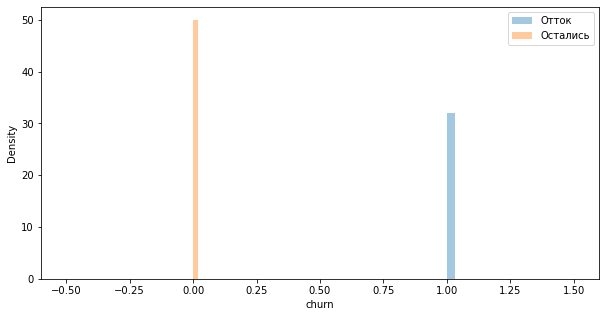

In [12]:
for i in df.columns:
    
    plt.figure(figsize = (10,5))
    sns.distplot(gone[i])
    sns.distplot(not_gone[i])
    plt.xlabel(i)
    plt.legend(['Отток', 'Остались'])
    plt.show()

Судя по графикам, можем заключить, что: 

1) Пол никак не влияет на отток клиента

2) Большая часть ушедших клиентов не являются сотрудниками компании-партнёра клуба или участниками акции «приведи друга»

3) Огромна часть ушедших клиентов имелла абонемент на 1 месяц. 

4) Отток клиентов значительно ниже, если они посещают групповые занятия

5) Уходят более молодые клиенты, от 20 до 30 лет.

6) Ушедшие клиенты тратили больше денег на прочие услуги фитнес-центра

7) Основной отток клиентов происходит в первые 3 месяца после обращения в фитнес-клуб

8) Ушедшие клиенты реже посещали зал, примерно на 1-2 раза в неделю меньше, чем те, кто остался



## Матрица корреляций 

In [13]:
cm = df.corr()
cm

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
gender,1.000000,0.006699,-0.010463,-0.005033,-0.008542,0.000502,0.017879,0.013807,-0.009334,-0.001281,0.013579,0.014620,0.009156,0.000708
near_location,0.006699,1.000000,-0.005119,0.210964,-0.015763,0.150233,0.154728,0.058358,0.040761,0.143961,0.070921,0.043127,0.062664,-0.128098
partner,-0.010463,-0.005119,1.000000,0.451960,0.009970,0.306166,0.022710,0.047480,0.022941,0.294632,0.061229,0.024938,0.045561,-0.157986
promo_friends,-0.005033,0.210964,0.451960,1.000000,0.001982,0.244552,0.120170,0.050113,0.036898,0.239553,0.072721,0.028063,0.053768,-0.162233
phone,-0.008542,-0.015763,0.009970,0.001982,1.000000,-0.006893,-0.010099,-0.011403,0.009279,-0.011196,-0.018801,0.008340,0.013375,-0.001177
contract_period,0.000502,0.150233,0.306166,0.244552,-0.006893,1.000000,0.169991,0.138249,0.111445,0.973064,0.170725,0.096211,0.159407,-0.389984
group_visits,0.017879,0.154728,0.022710,0.120170,-0.010099,0.169991,1.000000,0.080934,0.032079,0.163703,0.075853,0.056695,0.075923,-0.175325
age,0.013807,0.058358,0.047480,0.050113,-0.011403,0.138249,0.080934,1.000000,0.080240,0.134511,0.164693,0.119953,0.183095,-0.404735
avg_additional_charges_total,-0.009334,0.040761,0.022941,0.036898,0.009279,0.111445,0.032079,0.080240,1.000000,0.113958,0.079028,0.044426,0.079570,-0.198697
month_to_end_contract,-0.001281,0.143961,0.294632,0.239553,-0.011196,0.973064,0.163703,0.134511,0.113958,1.000000,0.161078,0.085387,0.147605,-0.381393


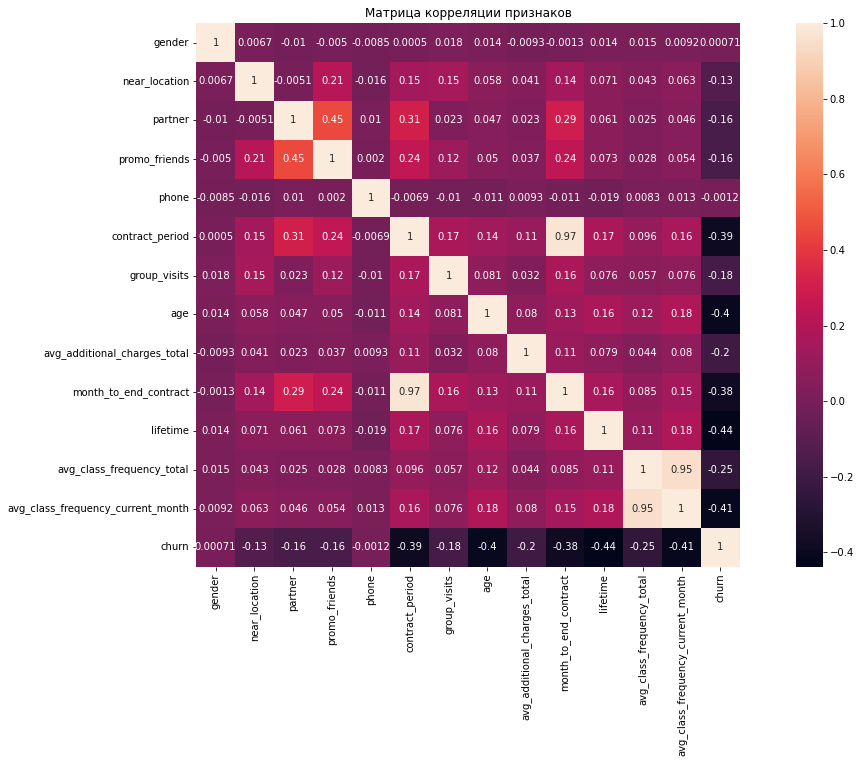

In [14]:
plt.figure(figsize=(20,10))


sns.heatmap(cm, annot=True, square=True) 

plt.title('Матрица корреляции признаков')
plt.show()


На графике видим, что очень сильно коррелируют пункты 'Avg_class_frequency_total' и 'Avg_class_frequency_current_month' а также 'Contract_period' и  'Month_to_end_contract'.  

Это взаимозависимые переменные.  

Сильной корреляции с целевой переменной Churn - не выявлено 

 

# Модель прогнозирования оттока клиентов

In [15]:
#разделим наши данные на признаки (матрица X) и целевую переменную (y)
X = df.drop(['churn'], axis = 1)
y = df['churn']

#разделяем модель на обучающую и валидационную выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size =0.2, random_state=0)#ваш код здесь

#создадим объект класса StandardScaler и применим его к обучающей выборке
scaler = StandardScaler()
X_train_st = scaler.fit_transform(X_train) #обучаем scaler и одновременно трансформируем матрицу для обучающей выборки


#применяем стандартизацию к матрице признаков для тестовой выборки
X_test_st = scaler.transform(X_test)


# зададим алгоритм для нашей модели
model = LogisticRegression(solver='liblinear', random_state=0)

# обучим модель
model.fit(X_train, y_train)

# воспользуемся уже обученной моделью, чтобы сделать прогнозы
probabilities = model.predict_proba(X_test)[:, 1]

# бинарный прогноз
predictions = model.predict(X_test)

# выведим все  метрики для полученного прогноза
print('Accuracy: {:.2f}'.format(accuracy_score(y_test, predictions)))
print('Precision: {:.2f}'.format(precision_score (y_test, predictions)))
print('Recall: {:.2f}'.format(recall_score(y_test, predictions)))


Accuracy: 0.93
Precision: 0.86
Recall: 0.83


In [16]:
def print_all_metrics(y_true, y_pred, y_proba, title='Метрики классификации'):
    print(title)
    print('\tAccuracy: {:.2f}'.format(accuracy_score(y_true, y_pred)))
    print('\tPrecision: {:.2f}'.format(precision_score(y_true, y_pred)))
    print('\tRecall: {:.2f}'.format(recall_score(y_true, y_pred)))

In [17]:
# зададим алгоритм для новой модели на основе алгоритма случайного леса
rf_model = RandomForestClassifier(n_estimators = 100, random_state=0) 
# обучим модель случайного леса
rf_model.fit(X_train_st, y_train)
# воспользуемся уже обученной моделью, чтобы сделать прогнозы
rf_predictions = rf_model.predict(X_test_st)
rf_probabilities =rf_model.predict_proba(X_test_st)[:, 1]



In [18]:
print_all_metrics(
    y_test, 
    rf_predictions,
    rf_probabilities,
    title='Метрики для модели случайного леса:'
)

Метрики для модели случайного леса:
	Accuracy: 0.92
	Precision: 0.84
	Recall: 0.81


## Вывод:


Модель логистической регрессии показала себя лучше на основании метрик Accuracy, Precision, Recall

# Кластеризация клиентов

In [19]:
dataset = df.drop('churn', axis=1)

In [20]:
# обязательная стандартизация данных перед работой с алгоритмами
sc = StandardScaler()
X_sc = sc.fit_transform(X)

linked = linkage(X_sc, method = 'ward') 

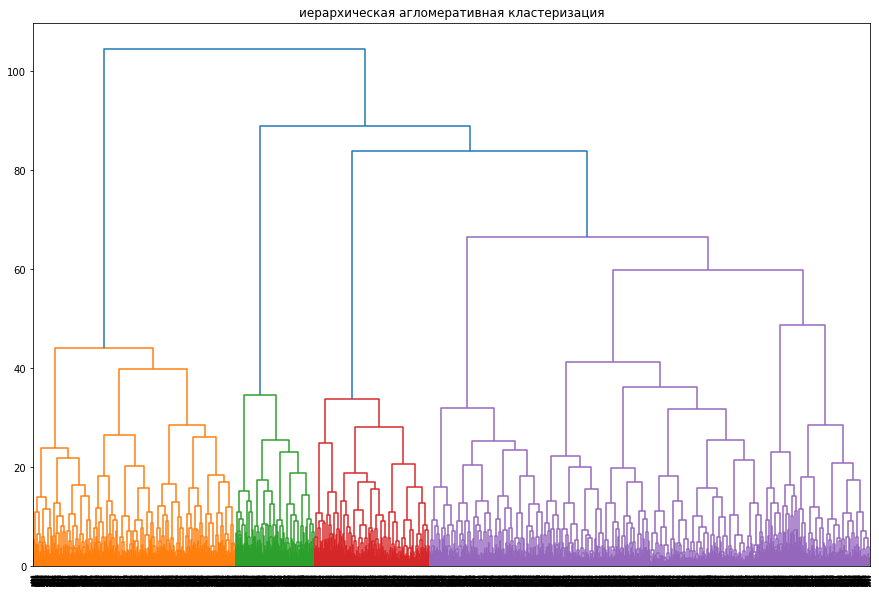

In [21]:
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('иерархическая агломеративная кластеризация')
plt.show() 

Предложенное оптимальное число кластеров  - 5

In [22]:
# определим функцию отрисовки графиков попарных признаков для кластеров
def show_clusters_on_plot(dataset, x_name, y_name, cluster_name):
    plt.figure(figsize=(5, 5))
    sns.scatterplot(
        dataset[x_name], dataset[y_name], hue=dataset[cluster_name], palette='Paired'
    )
    plt.title('{} vs {}'.format(x_name, y_name))
    plt.show()


# читаем данные

display(dataset.shape)

# стандартизируем данные
sc = StandardScaler()
x_sc = sc.fit_transform(dataset)

# задаём модель k_means с числом кластеров 5 и фиксируем значение random_state
km = KMeans(n_clusters=5, random_state=0)
# прогнозируем кластеры для наблюдений (алгоритм присваивает им номера от 0 до 2)
labels = km.fit_predict(x_sc)

# сохраняем метки кластера в поле нашего датасета
dataset['cluster'] = labels
display(dataset.head())
# выводим статистику по средним значениям наших признаков по кластеру
display(dataset.groupby(['cluster']).mean())



(4000, 13)

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,cluster
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,1
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,3
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,3


,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month
cluster,,,,,,,,,,,,,
0,0.502970,0.959406,0.783168,0.574257,1.000000,10.889109,0.542574,29.982178,160.761016,9.954455,4.736634,1.982055,1.974789
1,0.522078,0.862338,0.470130,0.306494,0.000000,4.787013,0.425974,29.301299,143.957664,4.475325,3.924675,1.847220,1.716369
2,0.495050,0.000000,0.463366,0.079208,1.000000,2.352475,0.215842,28.477228,135.457501,2.198020,2.809901,1.660461,1.477324
3,0.485737,1.000000,0.350238,0.240095,1.000000,1.948494,0.341521,28.167987,131.622204,1.856577,2.440571,1.247634,1.012983
4,0.559666,0.976134,0.356802,0.230310,0.998807,2.669451,0.473747,30.125298,161.657905,2.459427,4.898568,2.852002,2.850161


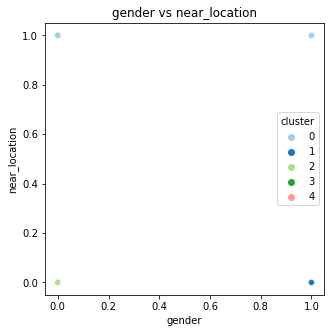

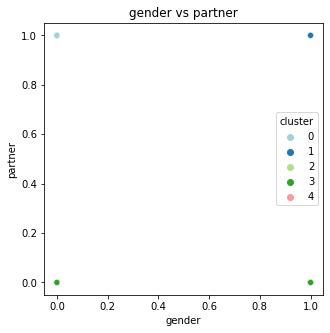

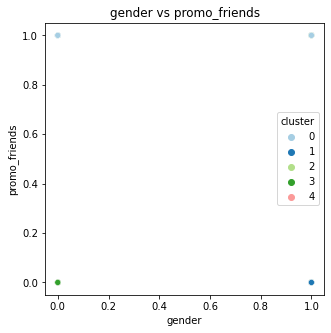

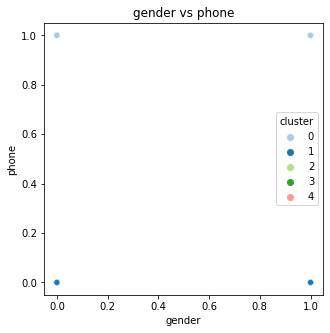

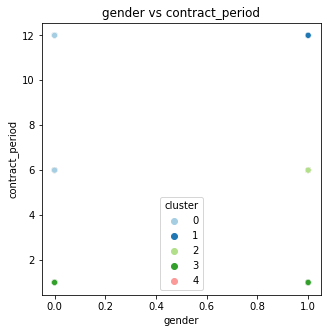

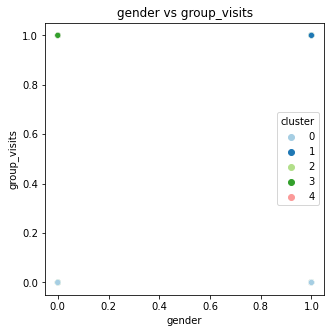

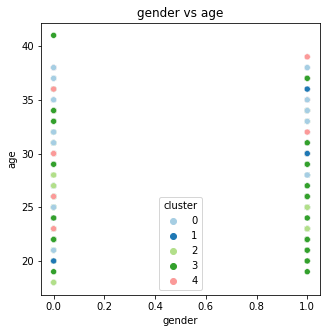

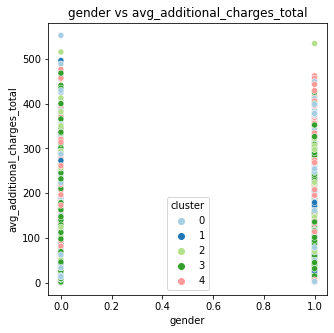

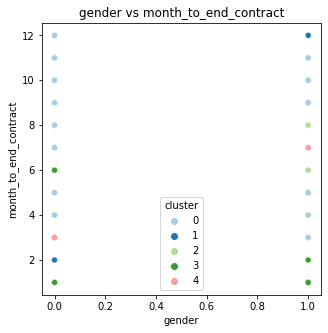

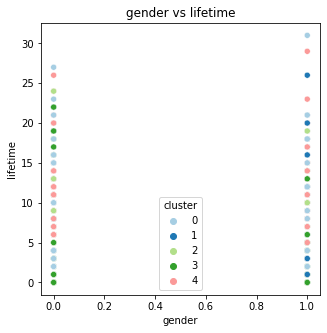

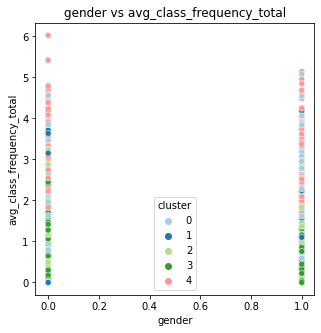

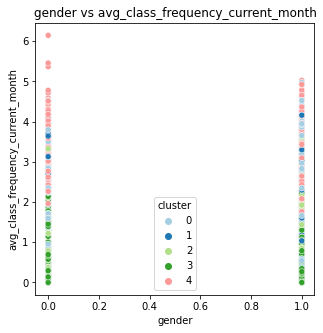

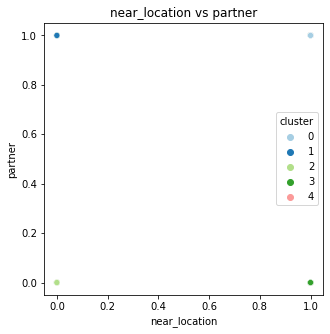

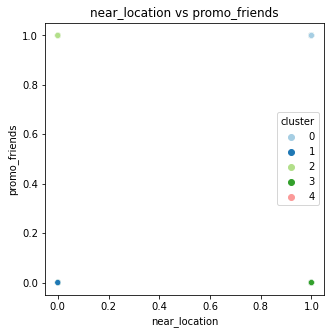

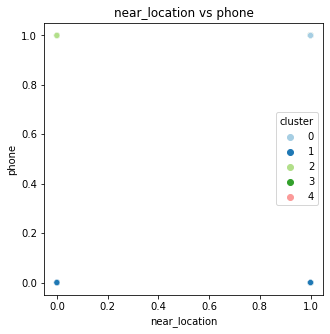

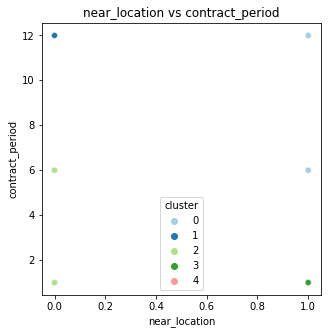

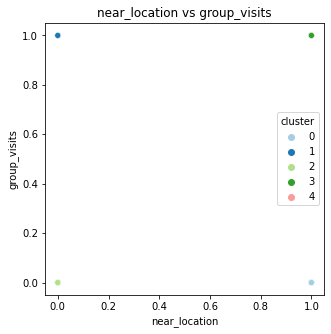

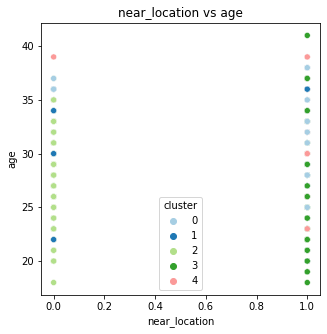

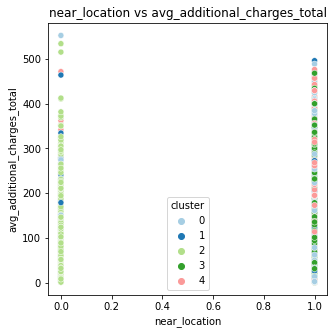

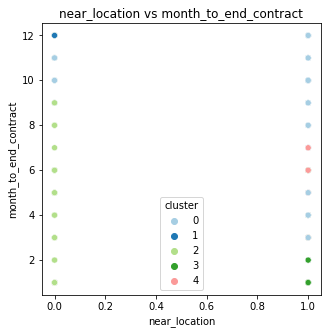

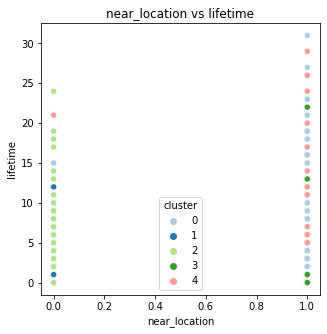

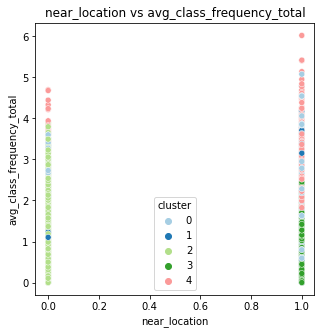

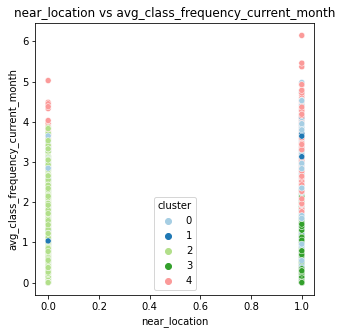

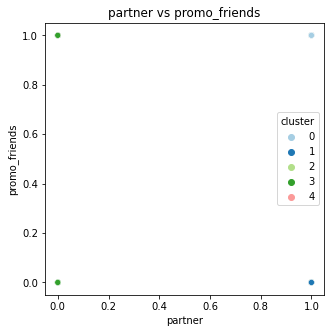

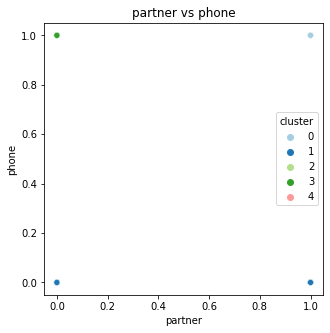

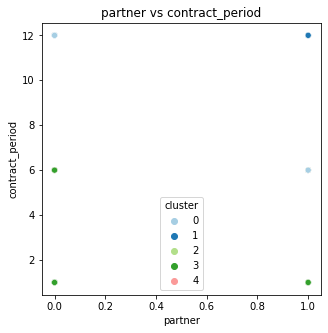

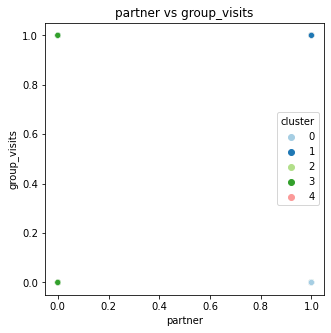

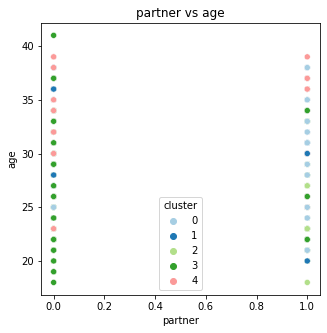

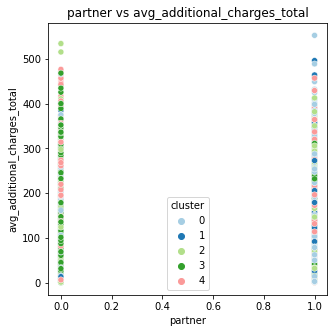

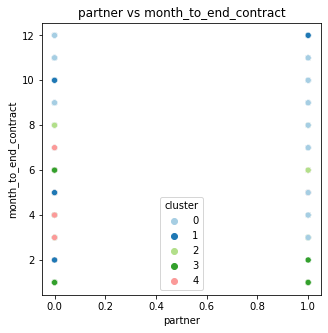

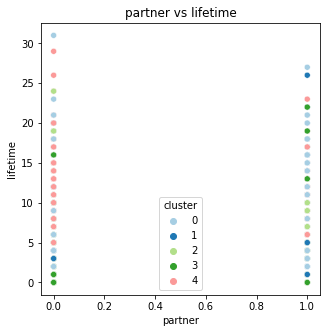

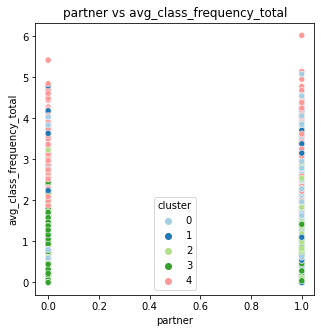

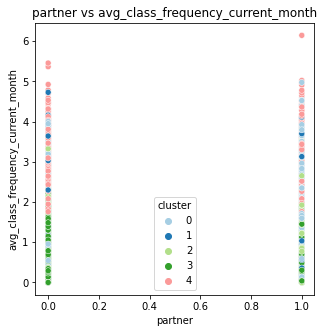

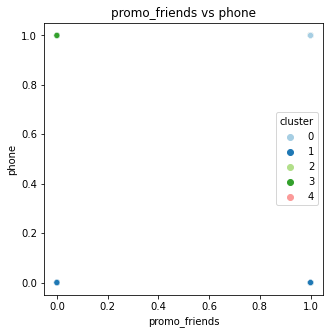

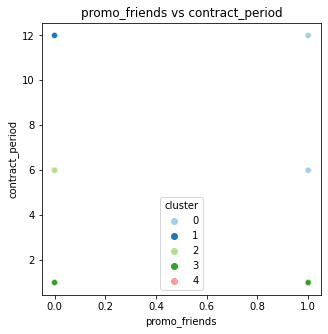

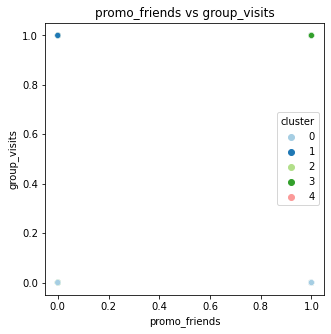

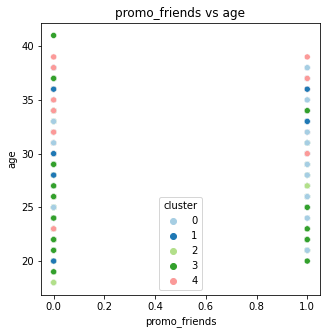

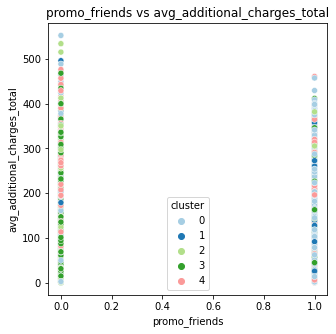

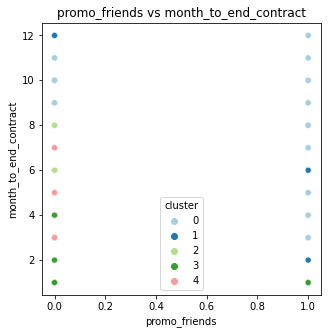

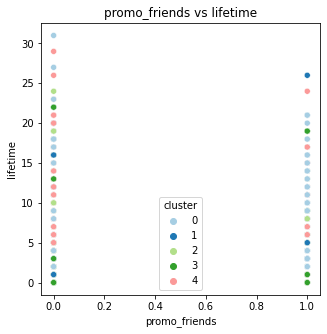

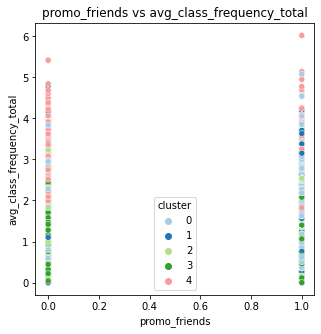

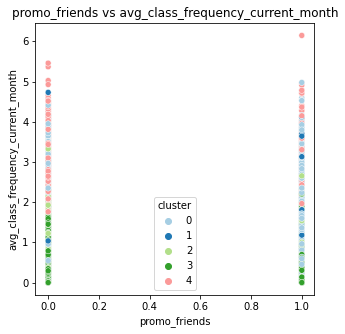

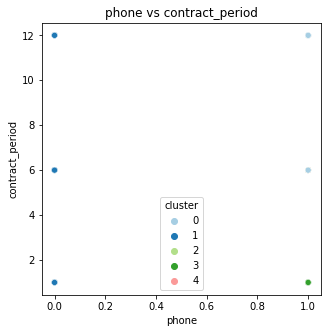

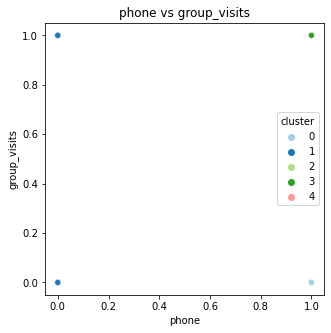

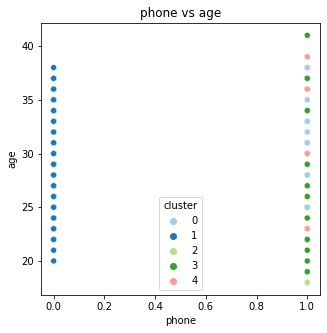

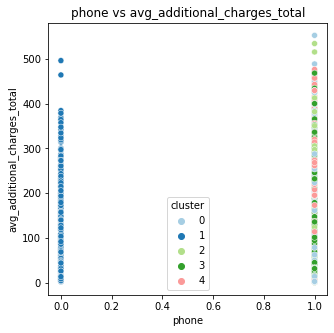

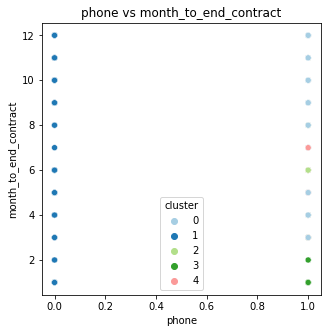

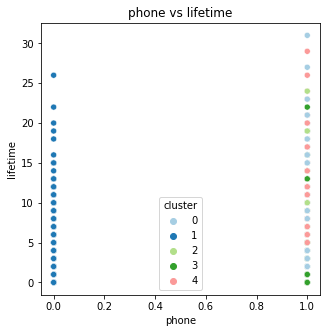

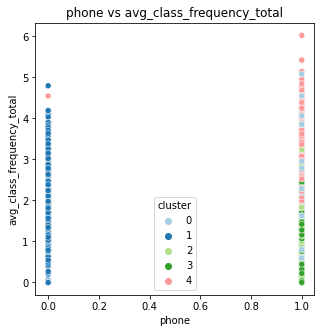

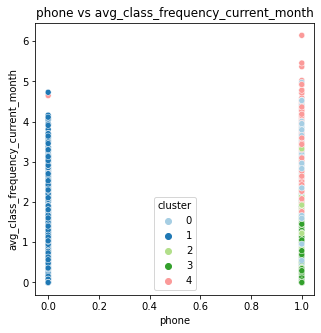

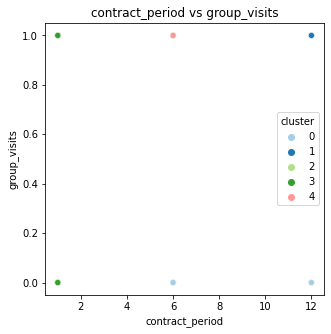

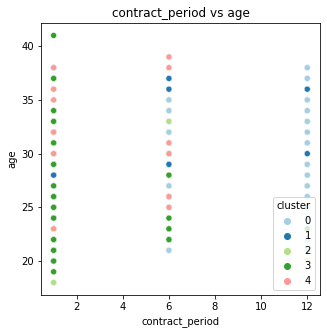

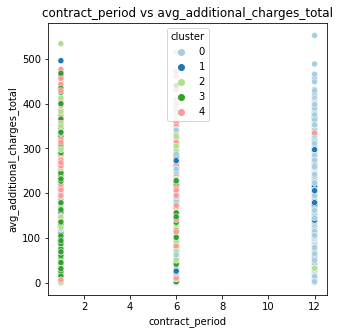

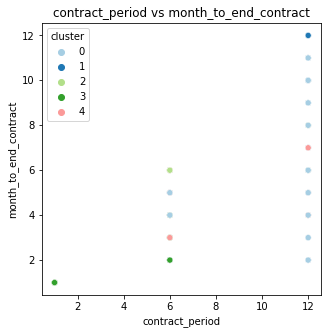

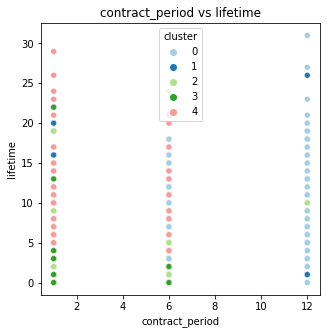

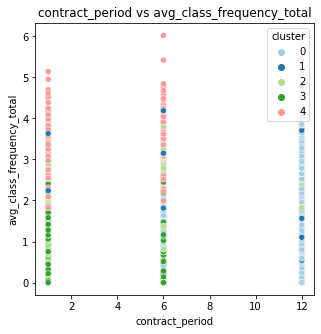

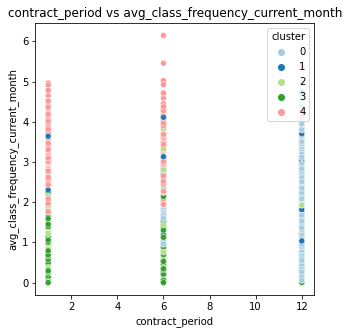

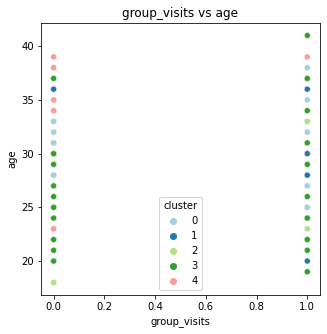

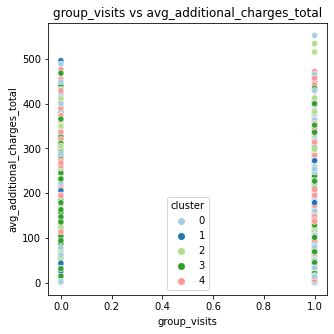

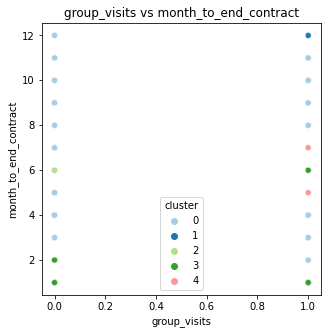

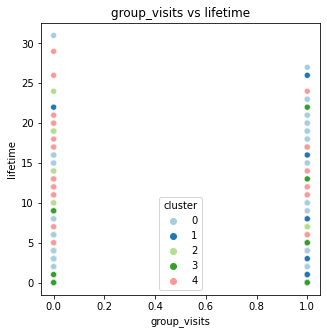

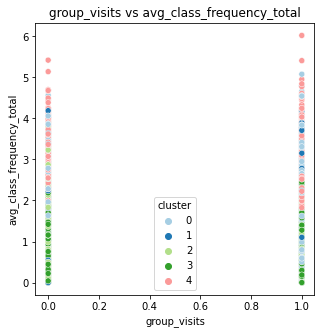

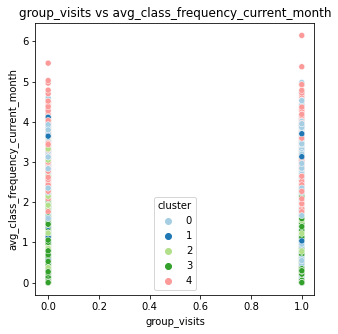

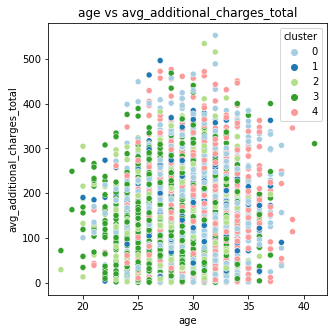

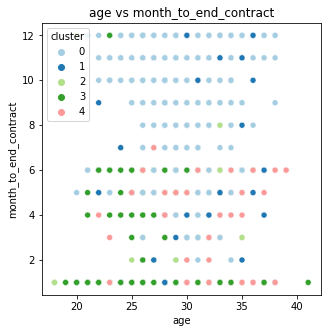

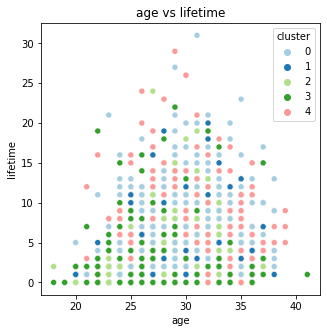

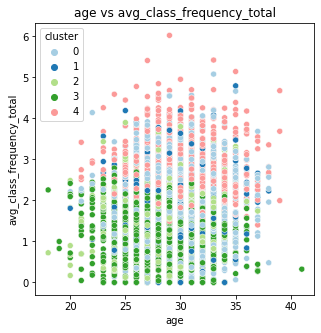

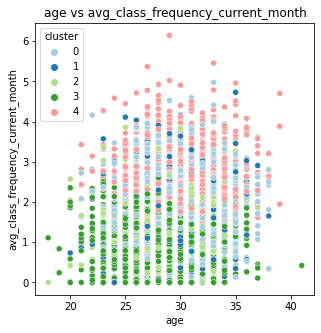

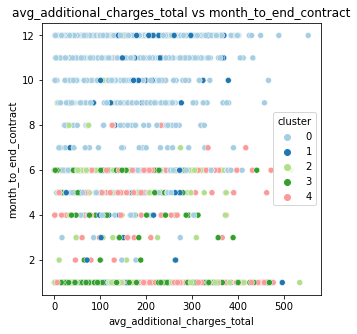

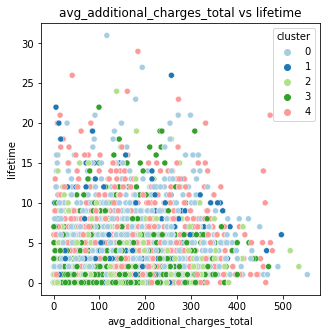

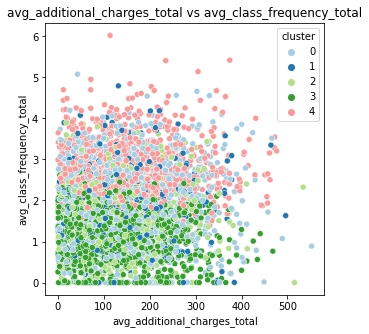

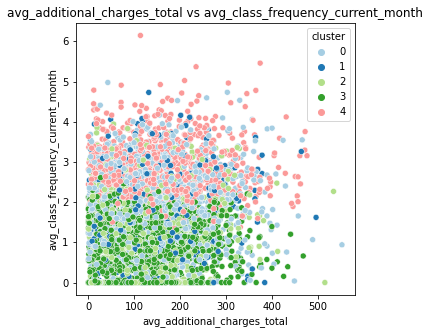

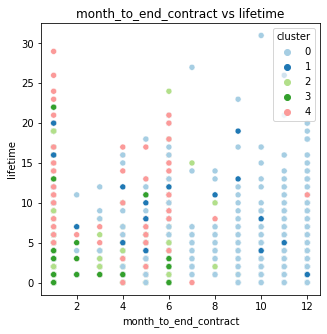

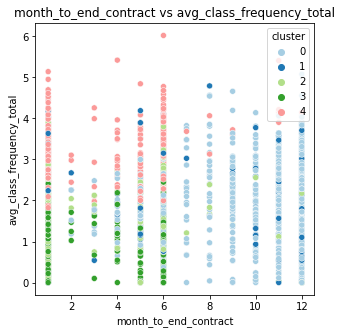

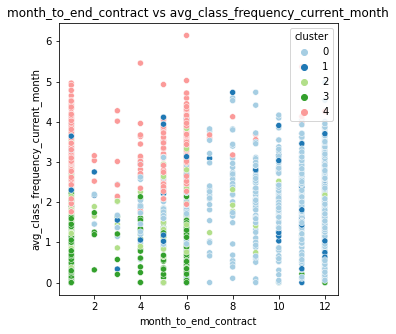

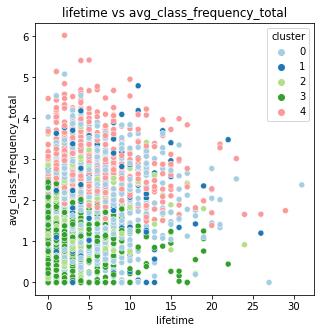

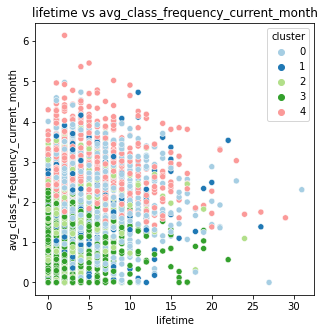

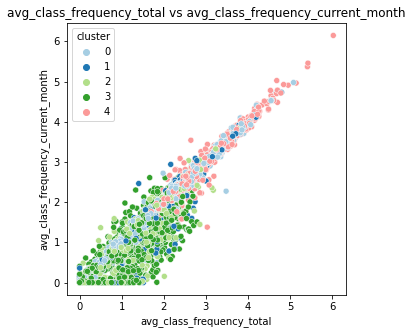

In [23]:
# отрисуем графики для попарных сочетаний признаков с разметкой по кластерам
col_pairs = list(itertools.combinations(dataset.drop('cluster', axis=1).columns, 2))
for pair in col_pairs:
    show_clusters_on_plot(dataset, pair[0], pair[1], 'cluster')
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "https://cs9.pikabu.ru/post_img/big/2019/11/26/6/157476170511756744.png")    

In [24]:
dataset['churn']=df['churn']
dataset.groupby('cluster').agg({'churn':'sum'}).reset_index().sort_values(by='churn', ascending=False)

,cluster,churn
3,3,649
2,2,224
1,1,103
4,4,57
0,0,28


In [25]:
dataset.groupby('cluster').agg('mean')

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
cluster,,,,,,,,,,,,,,
0,0.502970,0.959406,0.783168,0.574257,1.000000,10.889109,0.542574,29.982178,160.761016,9.954455,4.736634,1.982055,1.974789,0.027723
1,0.522078,0.862338,0.470130,0.306494,0.000000,4.787013,0.425974,29.301299,143.957664,4.475325,3.924675,1.847220,1.716369,0.267532
2,0.495050,0.000000,0.463366,0.079208,1.000000,2.352475,0.215842,28.477228,135.457501,2.198020,2.809901,1.660461,1.477324,0.443564
3,0.485737,1.000000,0.350238,0.240095,1.000000,1.948494,0.341521,28.167987,131.622204,1.856577,2.440571,1.247634,1.012983,0.514263
4,0.559666,0.976134,0.356802,0.230310,0.998807,2.669451,0.473747,30.125298,161.657905,2.459427,4.898568,2.852002,2.850161,0.068019


## Вывод:

Характерные особенности кластеров:

1) 0 кластер:

- Чаще всего живут рядом
- Чаще всего являются сотрудниками компаний партнеров
- Чаще приглашают друзей
- Покупают более длительные абонементы
- Больше тратят на доп.услуги
- Ходят довольно долго
- Около 2 посещений в неделю
- Почти не теряются 

2) 1 кластер:
- Чаще всего живут рядом
- Не оставляют номер телефонов(никогда)
- На 2 месте по продолжительности абонемента
- Ходят довольно долго
- Около 2 раз в неделю в среднем
- Теряется в среднем 26% клиентов

3) 2 кластер:
- Не живут рядом(никогда)
- Не приводят друзей
- Почти не посещают групповые занятия
- Имеют средний по продожительности абонемент
- Ходят в среднем 1,5 раза в неделю 
- Теряется в среднем 44% клиентов!

4) 3 кластер:
- Имеют самый низкий по продолжительности абонемент
- Живут рядом(всегда)
- Чаще всего являются самостоятельными клиентами(без компаний-партнеров)
- Тратят меньше всего денег на доп. услуги клуба
- Ходят в среднем 1 раз в неделю
- 51%! оттока в среднем

5) 4 кластер: 
- Почти всегда живут рядом
- Имеют среднюю продолжительность абонемента
- Иногда посещают групповые занятия 
- Больше всех тртатя на доп. услуги клуба
- Довольно долго ходят
- Около 3 посещений в неделю 
- Почти не отваливаются 

Больше всего отток у 2 и 3 кластера. Замента корреляция оттока к посещениям в неделю - чем реже ходит человек - тем вероятнее он "отвалится"

# Выводы:


В ходе проекта мы: 

- Познакомились с данными, не выявили пропусков или дубликатов, привели названия колонок к нижнему регистру

- Провели EDA, выяснили, что:
 

    1) Пол никак не влияет на отток клиента

    2) Большая часть ушедших клиентов не являются сотрудниками компании-партнёра клуба или участниками акции «приведи друга»

    3) Огромна часть ушедших клиентов имелла абонемент на 1 месяц. 

    4) Отток клиентов значительно ниже, если они посещают групповые занятия

    5) Уходят более молодые клиенты, от 20 до 30 лет.

    6) Ушедшие клиенты тратили больше денег на прочие услуги фитнес-центра

    7) Основной отток клиентов происходит в первые 3 месяца после обращения в фитнес-клуб

    8) Ушедшие клиенты реже посещали зал, примерно на 1-2 раза в неделю меньше, чем те, кто остался

- Построили матрицу корреляции и не выявили ни одной сильной корреляции переменных с целевой переменной Churn(отток)

- Создали и обучили модель прогнозирования оттока клиентов двумя способами, логистической регрессией и случайным лесом. Сравнив модели по метрикам accuracy, precision и recall выявили, что лучше всего себя показывает логистическая регрессия, её показатели:

        Accuracy: 0.93
        Precision: 0.86
        Recall: 0.83

- Сделали кластеризацию клиентов, выявили, что больший отток наблюдается у 2 и 3 Кластера, 44% и 51% соответсвенно. 


Рекомендации: 

- Детально изучить Характерные особенности кластеров, что бы лучше понимать тип клиентов. 
- Направить большую рекламную активность на привлечение целевых пользоваетелй 0 и 4 кластеров, т.к. эта категория клиентов меньше всего "отваливается" и тратит больше всего денег не только на абонементы, но и на доп услуги фитнес-клуба. 
- Учитывая выявленную корреляцию между кол-вом посещений в неделю и оттоком - мотивировать действующих клиентов на более частое посещение клуба
- Провести опрос отвалившихся клиентов для выявления зон роста. 
